# SD-HOC Implementation

## Introduction

The SD-HOC algorithm is a predictive model designed to estimate the number of people in a room using carbon dioxide (CO2) measurements. Human occupancy counting is a valuable task in various domains, such as building automation, energy management, and indoor air quality control. By leveraging the relationship between CO2 concentration and human presence, the SD-HOC algorithm offers a non-intrusive and cost-effective solution for occupancy estimation.

## Visualizing the data

### People Count RGB

We start by importing the necessary libraries and loading the data.

We were using JSON files to store the data.We prefered JSON files because they are easy to read and write, lightweight, and can be parsed easily. We used the JSON library to load the data and convert it to a pandas dataframe.

In [1]:
import sys
import os
import plotly.express as px


from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


head, _ = os.path.split(sys.path[0])
sys.path[0] = head

import src.utils as utils

# load the data
files =[ '../data/dataset/V6AD_20210211.json',
         '../data/dataset/V6AD_20210212.json',
         '../data/dataset/V6AD_20210213.json',
         '../data/dataset/V6AD_20210214.json',
         '../data/dataset/V6AD_20210215.json',
         '../data/dataset/V6AD_20210216.json']


# # create the dataframes
df = utils.create_df(files)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14685 entries, 0 to 14684
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   deviceID            4209 non-null   object 
 1   time                14685 non-null  int64  
 2   peoplecount_ir_est  4209 non-null   float64
 3   ir_raw_data_array   4209 non-null   object 
 4   occupancy           14685 non-null  int64  
 5   peoplecount_rgb     14685 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 688.5+ KB


As we can see below, the data is stored in a pandas dataframe. The dataframe contains 5 columns: 
- `deviceID` - the ID of the device that collected the data
- `time` - the timestamp of the measurement
- `peoplecount_ir_est` - the number of people in the room estimated by the IR sensor
- `ir_raw_data_array` - the raw data collected by the IR sensor
- `occupancy` - whether the room is occupied or not
- `peoplecount_rgb` - the number of people in the room estimated by the RGB sensor

 > **NB:** The peoplecount_rgb column was supervised by the user. The user had to manually input the number of people in the room at the time of the measurement. This was done to have a ground truth to compare the SD-HOC algorithm's predictions to.


In [3]:
df.head()

deviceID           time  peoplecount_ir_est  \
0               None  1612998020125                 NaN   
1               None  1612998074256                 NaN   
2  MS-IPac67b205b3b7  1612998084000                 0.0   
3               None  1612998136051                 NaN   
4               None  1612998197341                 NaN   

                                   ir_raw_data_array  occupancy  \
0                                               None          0   
1                                               None          0   
2  [994, 982, 991, 965, 931, 917, 886, 877, 912, ...          0   
3                                               None          0   
4                                               None          0   

   peoplecount_rgb  
0               -7  
1                0  
2                0  
3                0  
4                0

A quick overview of the data shows that the data is not clean. The NaN values in deviceID mean that this was only the mesure of the RGB sensor.   
Also some "-7" values in the peoplecount_rgb column are due the server problems.

We can also see that the time is the number of seconds since the epoch. We will convert it to a datetime object for easier manipulation.

We are gonna store the deviceID in a variable because we might need it later.   
We will transform the time column to a datetime object and only keep the columns we need.

In [4]:
# keep only the columns we need
device_id = df['deviceID'].unique()[1]
print(device_id)

# transform epoch time to datetime
df.loc[:, 'time'] = df['time'].apply(utils.epoch_to_datetime)

df = df[['time', 'peoplecount_rgb']]

# delete all rows with peoplecount_rgb = -7
df = df[df['peoplecount_rgb'] != -7]

MS-IPac67b205b3b7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14185 entries, 1 to 14684
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             14185 non-null  datetime64[ns]
 1   peoplecount_rgb  14185 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 332.5 KB


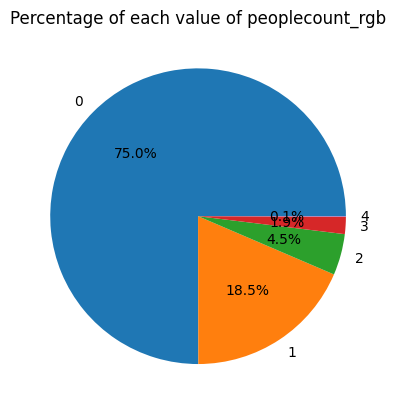

In [6]:
# Calculate value counts for the peoplecount_rgb column
value_counts = df['peoplecount_rgb'].value_counts()
fig = px.pie(values=value_counts.values, names=value_counts.index, title='Percentage of each value of peoplecount_rgb')
fig.show()
# use matplotlib to plot the same pie chart (for github)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%') 
ax.set_title('Percentage of each value of peoplecount_rgb')
plt.show()



As we can see, there are a lot of 0 values in the peoplecount_rgb column. It's okay because these are time series data.

### Time series plot

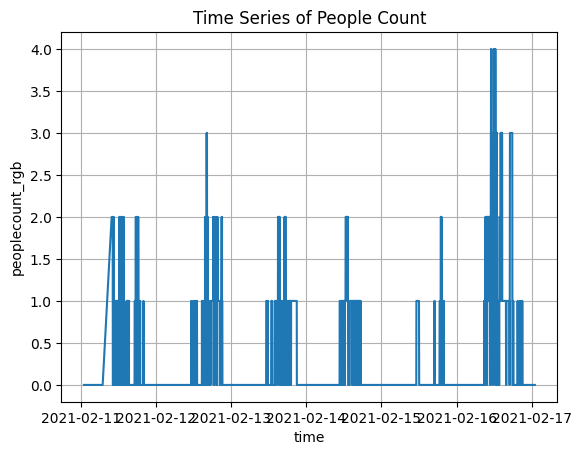

In [7]:
# plot time series of people count
utils.plot_time_series(df,'peoplecount_rgb',matplotlib = False,first = True)
utils.plot_time_series(df,'peoplecount_rgb',matplotlib = True,first = False)

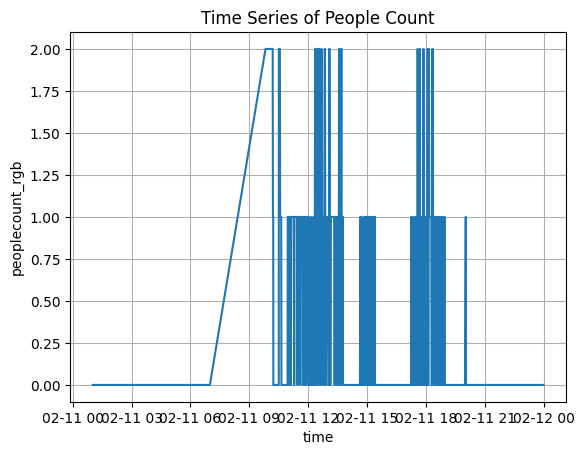

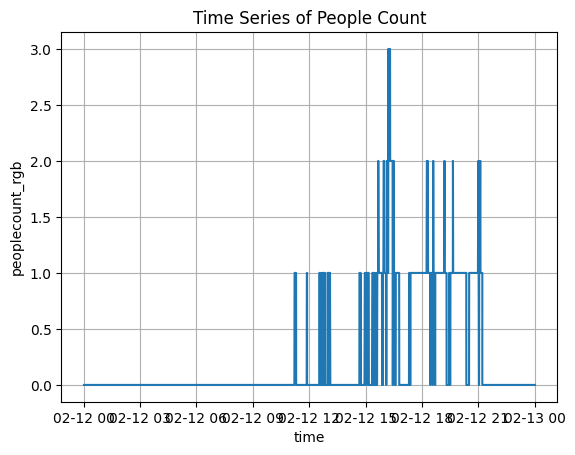

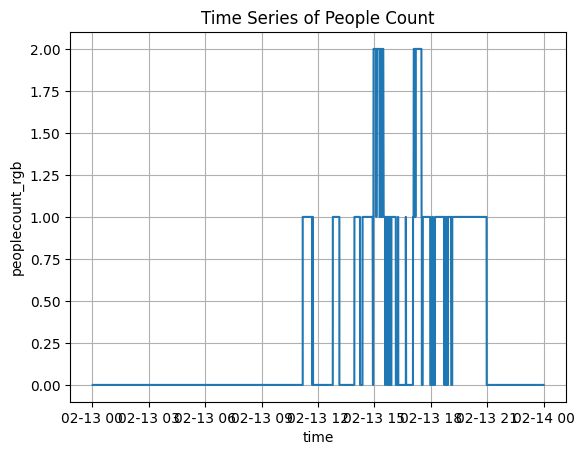

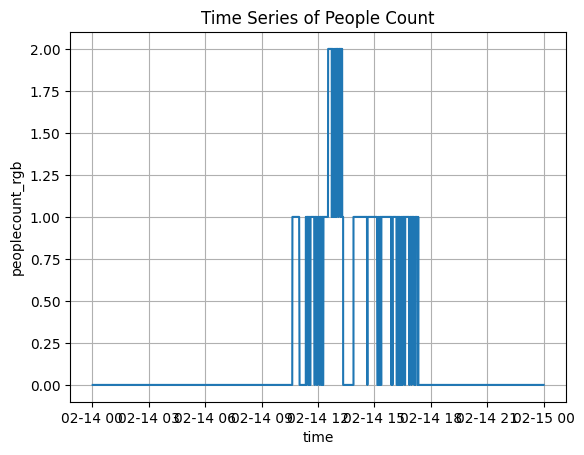

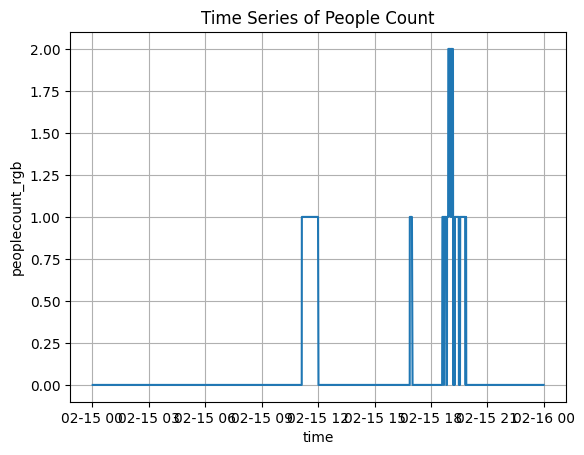

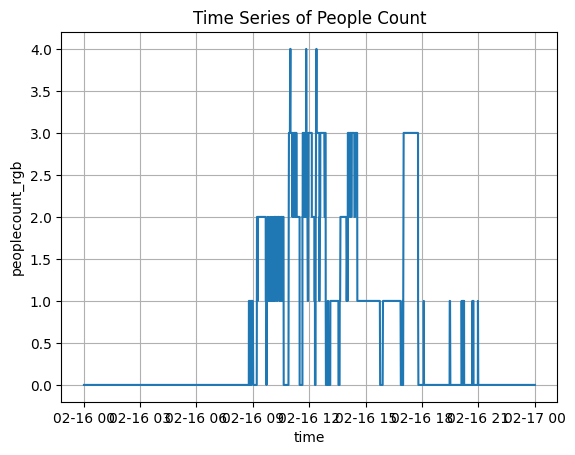

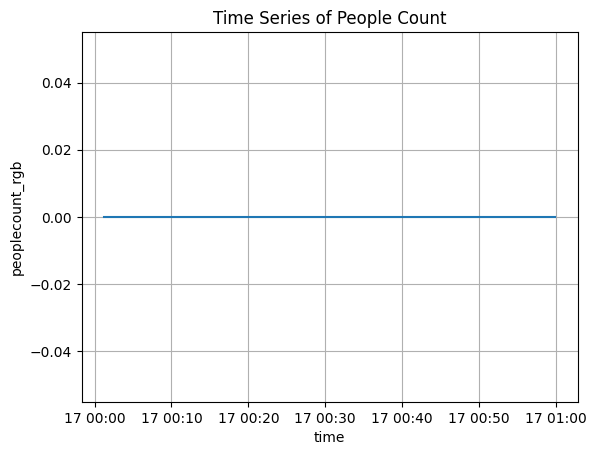

In [8]:
# plot time series of people count for each day
utils.plot_time_series_dbd(df,'peoplecount_rgb','People Count',matplotlib = False, first = True)
utils.plot_time_series_dbd(df,'peoplecount_rgb','People Count',matplotlib = True, first = False)

### CO2

In [9]:
import pandas as pd

df_co2 = pd.read_csv(
    '../data/VTEC-Device_MS-IPac67b205b3df_2021-02-11_00_00_00-2021-02-16_23_59_59.csv', sep=';')

In [10]:
df_co2

timestamp  lightintensity  tvoc   noise  humidity temperature  \
0      11-2-2021 00:00:02             NaN   NaN     NaN       NaN       10,55   
1      11-2-2021 00:00:26             NaN   NaN  40,921       NaN         NaN   
2      11-2-2021 00:01:09             NaN   NaN   40,81       NaN         NaN   
3      11-2-2021 00:01:10             NaN   NaN     NaN       NaN         NaN   
4      11-2-2021 00:01:35             NaN   NaN  41,972       NaN         NaN   
...                   ...             ...   ...     ...       ...         ...   
51148  16-2-2021 23:59:14             NaN   NaN     NaN       NaN         NaN   
51149  16-2-2021 23:59:38             NaN   NaN     NaN       NaN         NaN   
51150  16-2-2021 23:59:38             NaN   5.0     NaN       NaN         NaN   
51151  16-2-2021 23:59:39             NaN   NaN     NaN       NaN         NaN   
51152  16-2-2021 23:59:39             NaN   NaN  38,125       NaN         NaN   

       occupancy  co2-ndir  pm2.5  pm10  peoplecount           deviceID  \
0            NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
1            NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
2            NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
3            NaN       NaN    NaN   NaN          0.0  MS-IPac67b205b3df   
4            NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
...          ...       ...    ...   ...          ...                ...   
51148        NaN     422.0    NaN   NaN          NaN  MS-IPac67b205b3df   
51149        NaN       NaN    NaN   NaN          0.0  MS-IPac67b205b3df   
51150        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
51151        NaN       NaN    NaN   2.0          NaN  MS-IPac67b205b3df   
51152        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   

       EpochTime/UnixTime ( UTC )  
0                    1.612998e+09  
1                    1.612998e+09  
2                    1.612998e+09  
3                    1.612998e+09  
4                    1.612998e+09  
...                           ...  
51148                1.613516e+09  
51149                1.613516e+09  
51150                1.613516e+09  
51151                1.613516e+09  
51152                1.613516e+09  

[51153 rows x 13 columns]

In [11]:
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51153 entries, 0 to 51152
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   51153 non-null  object 
 1   lightintensity              4993 non-null   float64
 2   tvoc                        13687 non-null  float64
 3   noise                       13083 non-null  object 
 4   humidity                    11 non-null     float64
 5   temperature                 5336 non-null   object 
 6   occupancy                   2582 non-null   float64
 7   co2-ndir                    5531 non-null   float64
 8   pm2.5                       581 non-null    float64
 9   pm10                        1086 non-null   float64
 10  peoplecount                 4244 non-null   float64
 11  deviceID                    51153 non-null  object 
 12  EpochTime/UnixTime ( UTC )  51153 non-null  float64
dtypes: float64(9), object(4)
memory

In [12]:
# keep only time and non nan co2 columns
df_co2 = df_co2[['timestamp', 'co2-ndir']].dropna()

In [13]:
# rename columns
df_co2.columns = ['time', 'co2']

In [14]:
df_co2.co2.unique()
pd.to_datetime(df_co2.time)

14      2021-11-02 00:03:48
22      2021-11-02 00:04:34
35      2021-11-02 00:08:00
77      2021-11-02 00:18:49
135     2021-11-02 00:33:49
                ...        
51123   2021-02-16 23:55:48
51128   2021-02-16 23:56:57
51135   2021-02-16 23:58:28
51142   2021-02-16 23:59:08
51148   2021-02-16 23:59:14
Name: time, Length: 5531, dtype: datetime64[ns]

In [15]:
# plot time series of co2
df_co2.head()

time    co2
14   11-2-2021 00:03:48  454.0
22   11-2-2021 00:04:34  462.0
35   11-2-2021 00:08:00  446.0
77   11-2-2021 00:18:49  453.0
135  11-2-2021 00:33:49  458.0

In [16]:
# delete all data after 2021-02-16 23:59:59
df_co2 = df_co2[df_co2['time'] < '2021-02-17']

In [17]:
utils.plot_time_series(df_co2,'co2',matplotlib = False,first = True)

In [18]:
df_co2.head()

time    co2
14  2021-11-02 00:03:48  454.0
22  2021-11-02 00:04:34  462.0
35  2021-11-02 00:08:00  446.0
77  2021-11-02 00:18:49  453.0
135 2021-11-02 00:33:49  458.0

In [19]:
df.head()

time  peoplecount_rgb        date
1 2021-02-11 01:01:14.256                0  2021-02-11
2 2021-02-11 01:01:24.000                0  2021-02-11
3 2021-02-11 01:02:16.051                0  2021-02-11
4 2021-02-11 01:03:17.341                0  2021-02-11
5 2021-02-11 01:03:19.000                0  2021-02-11

In [24]:
# Sort the CO2 dataframe by the timestamp
df_co2 = df_co2.sort_values('time')

# Nearest Neighbor Matching
df_matched = pd.merge_asof(df, df_co2, on='time', direction='nearest')

# Fuzzy Matching
time_window = pd.Timedelta(minutes=1)  # Define the time window (adjust as needed)
df_matched = pd.merge_asof(df, df_co2, on='time', tolerance=time_window)

In [25]:
df_matched.columns 

Index(['time', 'peoplecount_rgb', 'date', 'co2'], dtype='object')

In [26]:
# only keep the columns we need
df_matched = df_matched[['time', 'peoplecount_rgb', 'co2']]

In [27]:
df_matched.dropna(inplace=True)

In [28]:
df_matched

time  peoplecount_rgb    co2
4776  2021-02-13 00:01:12.887                0  429.0
4778  2021-02-13 00:02:14.841                0  445.0
4779  2021-02-13 00:03:15.992                0  451.0
4780  2021-02-13 00:03:54.000                0  434.0
4781  2021-02-13 00:04:14.427                0  434.0
...                       ...              ...    ...
14118 2021-02-16 23:56:18.171                0  435.0
14119 2021-02-16 23:57:16.414                0  419.0
14120 2021-02-16 23:57:56.000                0  419.0
14122 2021-02-16 23:59:16.006                0  422.0
14123 2021-02-16 23:59:55.000                0  422.0

[4488 rows x 3 columns]

In [34]:
utils.plot_time_series(df_matched,'peoplecount_rgb',matplotlib = False,first = True)
utils.plot_time_series(df_matched, 'peoplecount_rgb',matplotlib = True,first = False)

In [35]:
utils.plot_time_series(df_matched,'co2',matplotlib = False,first = True)
utils.plot_time_series(df_matched, 'co2',matplotlib = True,first = False)

In [32]:
utils.plot_time_series_dbd(df_matched,'peoplecount_rgb',matplotlib = False, first = True)
utils.plot_time_series_dbd(df_matched,'peoplecount_rgb',matplotlib = True, first = False)

In [33]:
utils.plot_time_series_dbd(df_matched,'co2',matplotlib = False, first = True)
utils.plot_time_series_dbd(df_matched,'co2',matplotlib = True, first = False)